# 0. Setup and data health

## General

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [3]:
# Data folders
from pathlib import Path

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'brexit': ax.axvspan(pd.Timestamp('2016-06'), pd.Timestamp('2017-06'),
                             color="orange", alpha=0.2, label='Post Brexit volatility'),
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FE7B4BA0", alpha=0.2, label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FE7B4BA0", alpha=0.2, label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FE7B4BA0", alpha=0.2, label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FB3B38", alpha=0.2, label='Energy-price crisis')
    }

## Data load

In [5]:
# Retail Sales Index ("predominantly food stores")
# The RSI data is from the UK Office for National Statistics
# https://www.ons.gov.uk/datasets/retail-sales-index/editions/time-series/versions/38
# The CSV file is downloaded manually and placed in the raw_data_dir
raw_csv_path_rsi = raw_data_dir / "retail-sales-index-time-series-v38-filtered-2025-08-05T21-21-08Z.csv"
df_rsi = pd.read_csv(raw_csv_path_rsi)
df_rsi_clean = df_rsi[['mmm-yy', 'v4_1']].copy()
df_rsi_clean = df_rsi_clean.rename(columns={'v4_1': 'Retail_sales_index', 'mmm-yy': 'Month'})
df_rsi_clean['Month'] = pd.to_datetime(df_rsi_clean['Month'], format='%b-%y')
print("\n")
df_rsi_clean.info()

# Consumer Confidence Index
# The CCF data is from the OECD
# https://data.oecd.org/leadind/consumer-confidence-index-cci.htm
# The CSV file is downloaded manually and placed in the raw_data_dir
raw_csv_path_ccf = raw_data_dir / "OECD.SDD.STES,DSD_STES@DF_CLI,+GBR.M.CCICP...AA....csv"
df_ccf = pd.read_csv(raw_csv_path_ccf)
df_ccf_clean = df_ccf[['TIME_PERIOD', 'OBS_VALUE']].copy()
df_ccf_clean = df_ccf_clean.rename(columns={'OBS_VALUE': 'Consumer_confidence', 'TIME_PERIOD': 'Month'})
df_ccf_clean['Month'] = pd.to_datetime(df_ccf_clean['Month'])
print("\n")
df_ccf_clean.info()

# Consumer Price Index
# The CPI data is from the UK Office for National Statistics
# https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7bu/mm23
# The CSV file is downloaded manually and placed in the raw_data_dir
raw_csv_path_cpi = raw_data_dir / "series-070825.csv"
df = pd.read_csv(raw_csv_path_cpi, skiprows=6, names=["Period", "CPI"]).dropna()
df = df[df["Period"].str.match(r"^\d{4}")]


def to_date(p):
    p = str(p).strip().upper()
    if " " not in p:
        return pd.to_datetime(f"{p}-07-01")
    yr, tail = p.split(" ", 1)
    if tail.startswith("Q"):
        q = int(tail[1])
        month = {1: 2, 2: 5, 3: 8, 4: 11}[q]
        return pd.to_datetime(f"{yr}-{month:02d}-01")
    else:
        return pd.to_datetime(f"{yr} {tail}", format="%Y %b")


df["Month"] = df["Period"].map(to_date)
df_cpi_clean = (
    df[["Month", "CPI"]]
    .astype({"CPI": float})
    .sort_values("Month")
    .reset_index(drop=True)
)
print("\n")
df_cpi_clean.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Month               126 non-null    datetime64[ns]
 1   Retail_sales_index  126 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.1 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Month                126 non-null    datetime64[ns]
 1   Consumer_confidence  126 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.1 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   637 non-nul

In [6]:
# Check for duplicates
print("RSI: ", df_rsi_clean['Month'].duplicated().any())
print("CCF: ", df_ccf_clean['Month'].duplicated().any())
print("CPI: ", df_cpi_clean['Month'].duplicated().any())

RSI:  False
CCF:  False
CPI:  True


In [7]:
# Remove duplicates inside each raw frame (keep last if any)
rsi = df_rsi_clean.drop_duplicates('Month', keep='last')
ccf = df_ccf_clean.drop_duplicates('Month', keep='last')
cpi = df_cpi_clean.drop_duplicates('Month', keep='last')

# Inner join: only months present in all three
common = rsi.merge(ccf, on='Month').merge(cpi, on='Month')

# Slice to the exact 126-month window (2015-01 to 2025-06)
start, end = pd.Timestamp('2015-01-01'), pd.Timestamp('2025-06-01')
idx = pd.date_range(start, end, freq='MS')

# Reindex to ensure all months are present, filling gaps with NaN
merged = (common.set_index('Month')
          .reindex(idx)
          .sort_index()
          .reset_index().rename(columns={'index': 'date'}))  # Gaps become NaN

# Ensure Month is the index and is datetime
merged = merged.set_index('date')

# Convert every date to the *end* of the same month
merged.index = pd.to_datetime(merged.index).to_period('M').to_timestamp('M')

print("Rows in 2015-01 → 2025-06:", len(merged))
print(merged.index.min(), merged.index.max())

Rows in 2015-01 → 2025-06: 126
2015-01-31 00:00:00 2025-06-30 00:00:00


In [8]:
# Default dataframe for analysis
merged.head()

,Retail_sales_index,Consumer_confidence,CPI
date,,,
2015-01-31,94.9,101.9632,101.3
2015-02-28,95.0,102.2298,101.1
2015-03-31,95.6,102.4168,100.9
2015-04-30,95.7,102.4100,100.5
2015-05-31,95.9,102.2814,100.4


In [9]:
# Dataframe to add features to
merged_with_features = merged.copy()
merged_with_features.head()

,Retail_sales_index,Consumer_confidence,CPI
date,,,
2015-01-31,94.9,101.9632,101.3
2015-02-28,95.0,102.2298,101.1
2015-03-31,95.6,102.4168,100.9
2015-04-30,95.7,102.4100,100.5
2015-05-31,95.9,102.2814,100.4


# 1. Global view

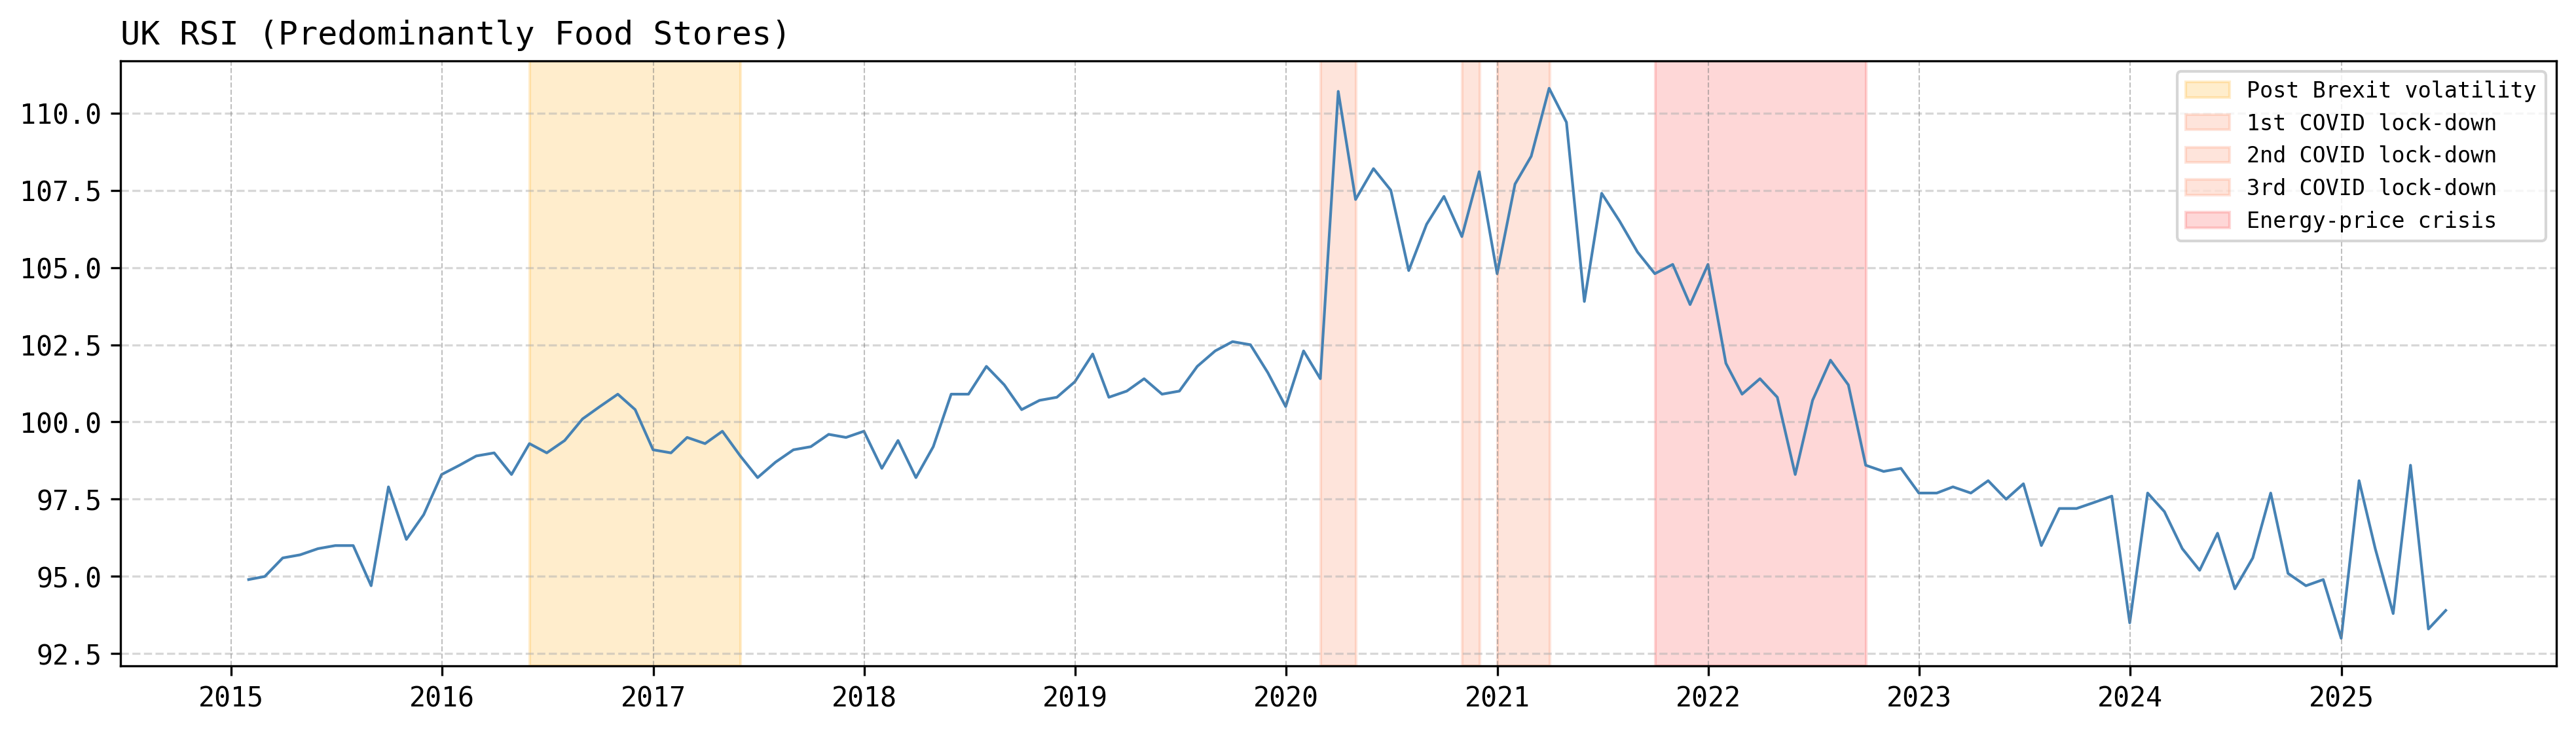

In [10]:
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=merged, x='date', y='Retail_sales_index', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI (Predominantly Food Stores)', loc='left')
plt.show()

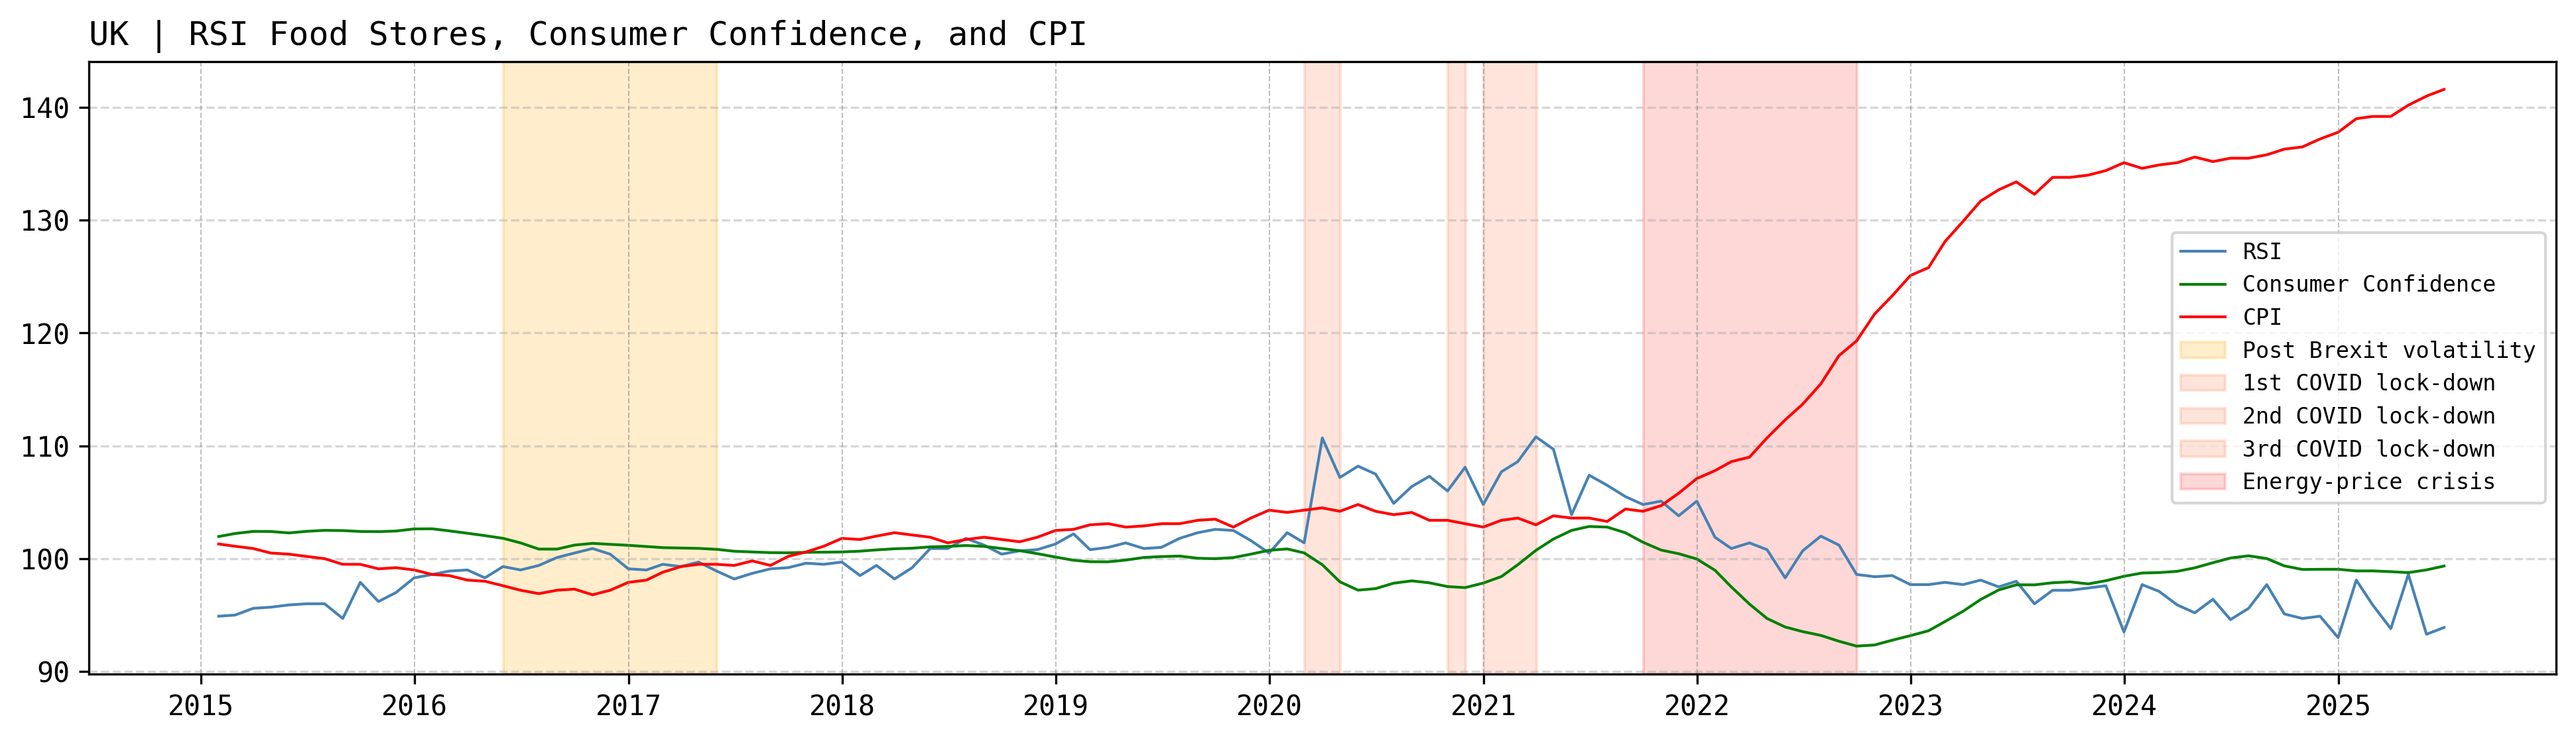

In [11]:
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=merged, x='date', y='Retail_sales_index', linewidth=1, color='steelblue', label='RSI')
ax = sns.lineplot(data=merged, x='date', y='Consumer_confidence', linewidth=1, color='green', label='Consumer Confidence')
ax = sns.lineplot(data=merged, x='date', y='CPI', linewidth=1, color='red', label='CPI')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK | RSI Food Stores, Consumer Confidence, and CPI', loc='left')
plt.show()

# 2. Trend, Seasonal & Stationarity

STL decomposition, ADF / KPSS tests to confirm whether differencing is needed

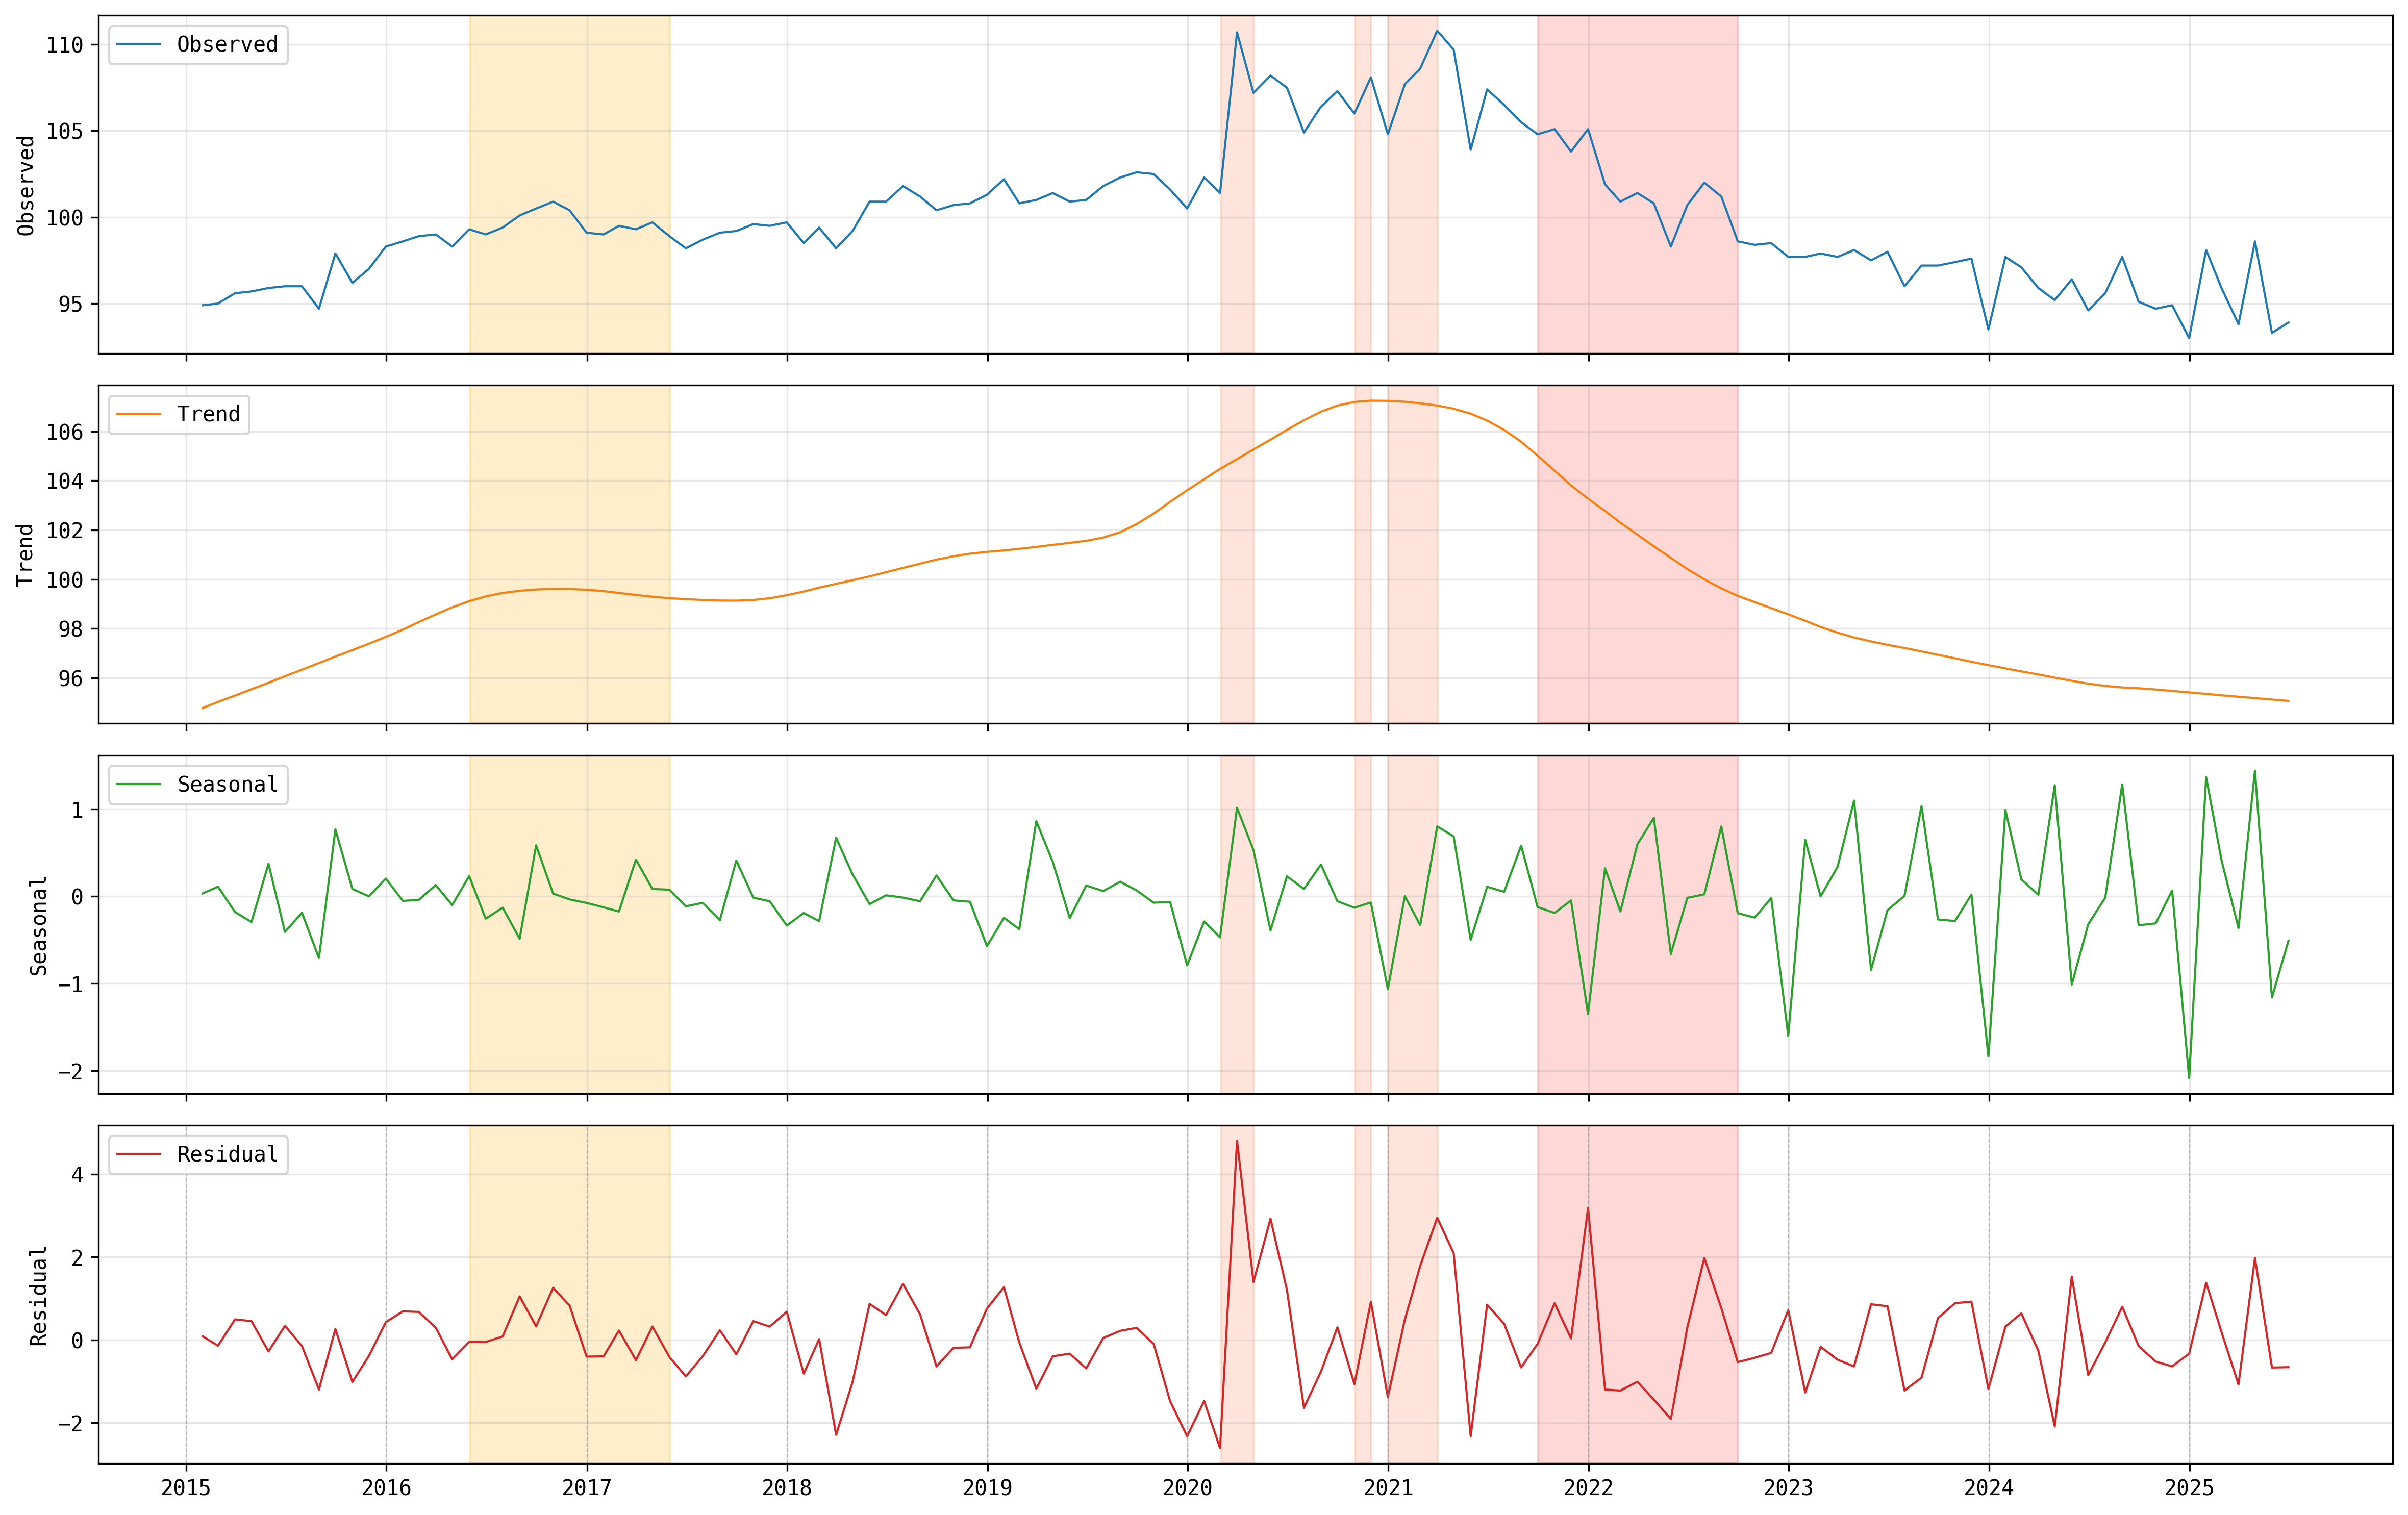

total volatility 3.916343938071558
seasonal volatility 0.5697296961661459
seasonal strength metric 0.1454748881035933
residual volatility 1.1353625324382242


In [12]:
from statsmodels.tsa.seasonal import STL

stl = STL(merged['Retail_sales_index'], seasonal=13, robust=False)
res = stl.fit()

observed = res.observed
trend = res.trend
seasonal = res.seasonal
resid = res.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), sharex=True, dpi=300)

ax1.plot(observed, label='Observed', color='#1f77b4', linewidth=1)
ax2.plot(trend, label='Trend', color='#ff7f0e', linewidth=1)
ax3.plot(seasonal, label='Seasonal', color='#2ca02c', linewidth=1)
ax4.plot(resid, label='Residual', color='#d62728', linewidth=1)

for ax, title in zip([ax1, ax2, ax3, ax4],
                     ['Observed', 'Trend', 'Seasonal', 'Residual']):
    ax.set_ylabel(title)
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)

    event_spans = add_event_spans(ax)

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

print("total volatility", merged['Retail_sales_index'].std())
print("seasonal volatility", res.seasonal.std())
print("seasonal strength metric", res.seasonal.std() / merged['Retail_sales_index'].std())
print("residual volatility", res.resid.std())

Seasonal patterns are present but not the dominant source of variation.  
Relatively high residual volatility, hence other factors beyond trend/seasonality significantly impact sale.  
Trend variance > Seasonal, hence differencing will be needed.  

In [13]:
# Augmented Dickey-Fuller on (a) raw series, (b) 1st-diff, (c) 1st-diff + seasonal-diff.

from statsmodels.tsa.stattools import adfuller


def adf_report(series, title):
    """Run ADF; return and print t-stat, p-value, lag length (AIC)."""
    res = adfuller(series, autolag='AIC', regression='c')
    t, p, lags = res[0], res[1], res[2]
    print(f"{title:30s} | t-stat: {t:8.3f} | p-value: {p:6.4f} | lags: {lags}")
    return t, p, lags


t0, p0, lag0 = adf_report(merged['Retail_sales_index'], "Raw series")

y_d1 = merged['Retail_sales_index'].diff().dropna()
t1, p1, lag1 = adf_report(y_d1, "1st difference")

y_d1_ds = (y_d1.diff(12)).dropna()
t2, p2, lag2 = adf_report(y_d1_ds, "1st diff + seasonal diff (lag=12)")

cases = [(0, p0), (1, p1), (2, p2)]
decision = next((d, p) for d, p in cases if p < 0.05)

# Decision rule: choose the minimal differencing order that rejects the unit-root at 5 %.
print("\nDecision:")
print(f"  Minimal differencing order that yields p < 0.05: d = {decision[0]}")
print(f"  p-value at that order: {decision[1]:.4f}")

Raw series                     | t-stat:   -0.983 | p-value: 0.7595 | lags: 4
1st difference                 | t-stat:   -7.591 | p-value: 0.0000 | lags: 3
1st diff + seasonal diff (lag=12) | t-stat:   -2.967 | p-value: 0.0381 | lags: 13

Decision:
  Minimal differencing order that yields p < 0.05: d = 1
  p-value at that order: 0.0000


# 3. Structural Breaks

Structural Break Tests, Machine Learning Approaches  
changepoint detection algorithms (PELT / Pruned Exact Linear Time, Bayesian changepoint analysis)  
Markov regime-switching models  
Structural break tests (Chow test, CUSUM)  
external economic indicators  

## PELT / Pruned Exact Linear Time

In [14]:
from ruptures import Pelt
import ruptures as rpt

In [15]:
data = merged['Retail_sales_index'].values

# Initialize PELT with different models
# 'rbf' = radial basis function kernel (good for general changes)
# 'l1' = L1 norm or 'l2' = L2 norm (good for mean changes)
# 'normal' = assumes Gaussian distribution

algo = Pelt(model='rbf', min_size=3)  # min_size prevents very short segments
result = algo.fit_predict(data, pen=10)  # sensitivity to changes, the higher the penalty, the fewer changepoints detected

# Remove the last point
changepoints = result[:-1]

print(f"Detected changepoints at indices: {changepoints}")
print(f"Corresponding dates: {[merged.index[i] for i in changepoints]}")

# Different penalty values to see sensitivity
penalties = [2, 5, 10, 15]
for pen in penalties:
    result = algo.fit_predict(data, pen=pen)
    print(f"Penalty {pen}: {len(result) - 1} changepoints at indices {result[:-1]}")

Detected changepoints at indices: [60, 85]
Corresponding dates: [Timestamp('2020-01-31 00:00:00'), Timestamp('2022-02-28 00:00:00')]
Penalty 2: 6 changepoints at indices [10, 40, 60, 85, 95, 110]
Penalty 5: 5 changepoints at indices [10, 40, 60, 85, 95]
Penalty 10: 2 changepoints at indices [60, 85]
Penalty 15: 0 changepoints at indices []


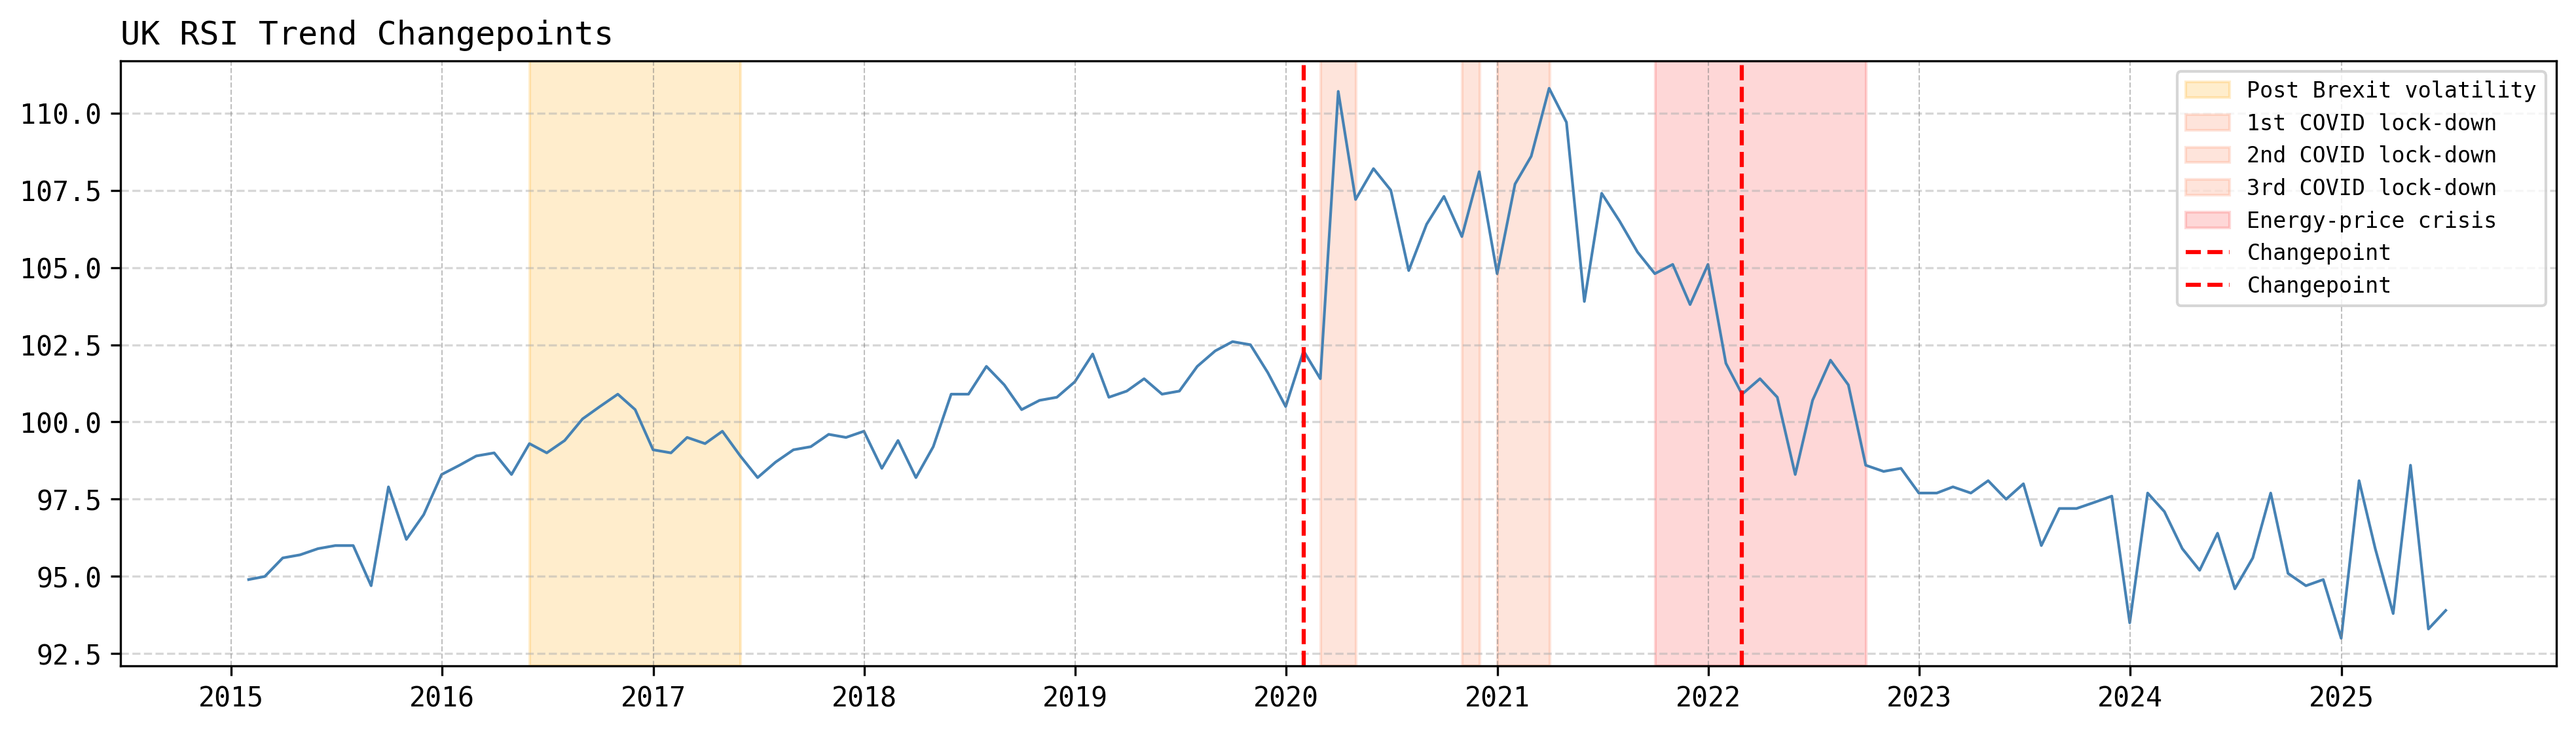

In [16]:
# Chart overlay with changepoints
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=merged, x='date', y='Retail_sales_index', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

event_spans = add_event_spans(ax)

# Change points
for cp in changepoints:
    plt.axvline(x=merged.index[cp], color='red', linestyle='--', alpha=1, linewidth=1.5, label='Changepoint')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI Trend Changepoints', loc='left')
plt.show()

In [17]:
# Create dummy variables for each changepoint
for cp in changepoints:
    merged_with_features[f'cp_{cp}'] = (np.arange(len(merged_with_features)) >= cp).astype(int)

"""
# Create interaction terms with a trend (if applicable)
uk['trend'] = np.arange(len(uk))
for cp in changepoints:
    uk[f'trend_cp_{cp}'] = uk['trend'] * uk[f'cp_{cp}']
"""
merged_with_features.head()

,Retail_sales_index,Consumer_confidence,CPI,cp_60,cp_85
date,,,,,
2015-01-31,94.9,101.9632,101.3,0,0
2015-02-28,95.0,102.2298,101.1,0,0
2015-03-31,95.6,102.4168,100.9,0,0
2015-04-30,95.7,102.4100,100.5,0,0
2015-05-31,95.9,102.2814,100.4,0,0


## Chow test

In [18]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from scipy import stats  # For F-distribution

y = merged['Retail_sales_index'].values
X = sm.add_constant(range(len(y)))
dates = merged.index

alpha_bonf = 0.05 / len(changepoints)

for k in changepoints:
    break_date = dates[k]
    n = len(y)

    # dummy: 0 before break, 1 from break onward
    D = np.zeros(n)
    D[k:] = 1

    # interaction
    X_full = np.column_stack((X, D, X[:, 1] * D))  # trend & interaction
    X_full = sm.add_constant(X_full)  # adds overall const

    # restricted: no break
    res_r = sm.OLS(y, sm.add_constant(X[:, 1])).fit()
    # unrestricted: allow break
    res_u = sm.OLS(y, X_full).fit()

    # Chow F-stat
    k_restrictions = 2  # number of restrictions (intercept and trend)
    df1 = k_restrictions
    df2 = res_u.df_resid
    f_stat = ((res_r.ssr - res_u.ssr) / df1) / (res_u.ssr / df2)
    p_val = 1 - stats.f.cdf(f_stat, df1, df2)

    print(f'Breakpoint index {k} → date {break_date.strftime("%Y-%m-%d")}')
    print(f'  Chow F({df1},{int(df2)}) = {f_stat:.3f}, p = {p_val:.4f}')

    if p_val < alpha_bonf:
        print("  → significant after Bonferroni\n")
    else:
        print("  → NOT significant after Bonferroni\n")

Breakpoint index 60 → date 2020-01-31
  Chow F(2,122) = 235.278, p = 0.0000
  → significant after Bonferroni

Breakpoint index 85 → date 2022-02-28
  Chow F(2,122) = 243.953, p = 0.0000
  → significant after Bonferroni



With p around 0, the null that the intercept and trend remain the same before vs after each date is rejected.  

## Optional: Markov regime-switching models

In [19]:
from statsmodels.tsa.regime_switching import markov_regression
from statsmodels.tsa.regime_switching import markov_autoregression

model_simple = markov_regression.MarkovRegression(
    merged['Retail_sales_index'],
    exog=None,
    k_regimes=3,
    trend='c',
    switching_trend=True,
    switching_variance=False  # Keep variance constant
)

results_simple = model_simple.fit(search_reps=20)
print(results_simple.summary())

c:\Users\mikha\Documents\GitHub\time-series-methods\.venv\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\mikha\Documents\GitHub\time-series-methods\.venv\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
c:\Users\mikha\Documents\GitHub\time-series-methods\.venv\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition prob

                        Markov Switching Model Results                        
Dep. Variable:     Retail_sales_index   No. Observations:                  126
Model:               MarkovRegression   Log Likelihood                -293.206
Date:                Fri, 08 Aug 2025   AIC                            606.413
Time:                        22:36:42   BIC                            634.776
Sample:                    01-31-2015   HQIC                           617.936
                         - 06-30-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.3254      2.788     36.706      0.000      96.862     107.789
                             Regime 1 parameters    

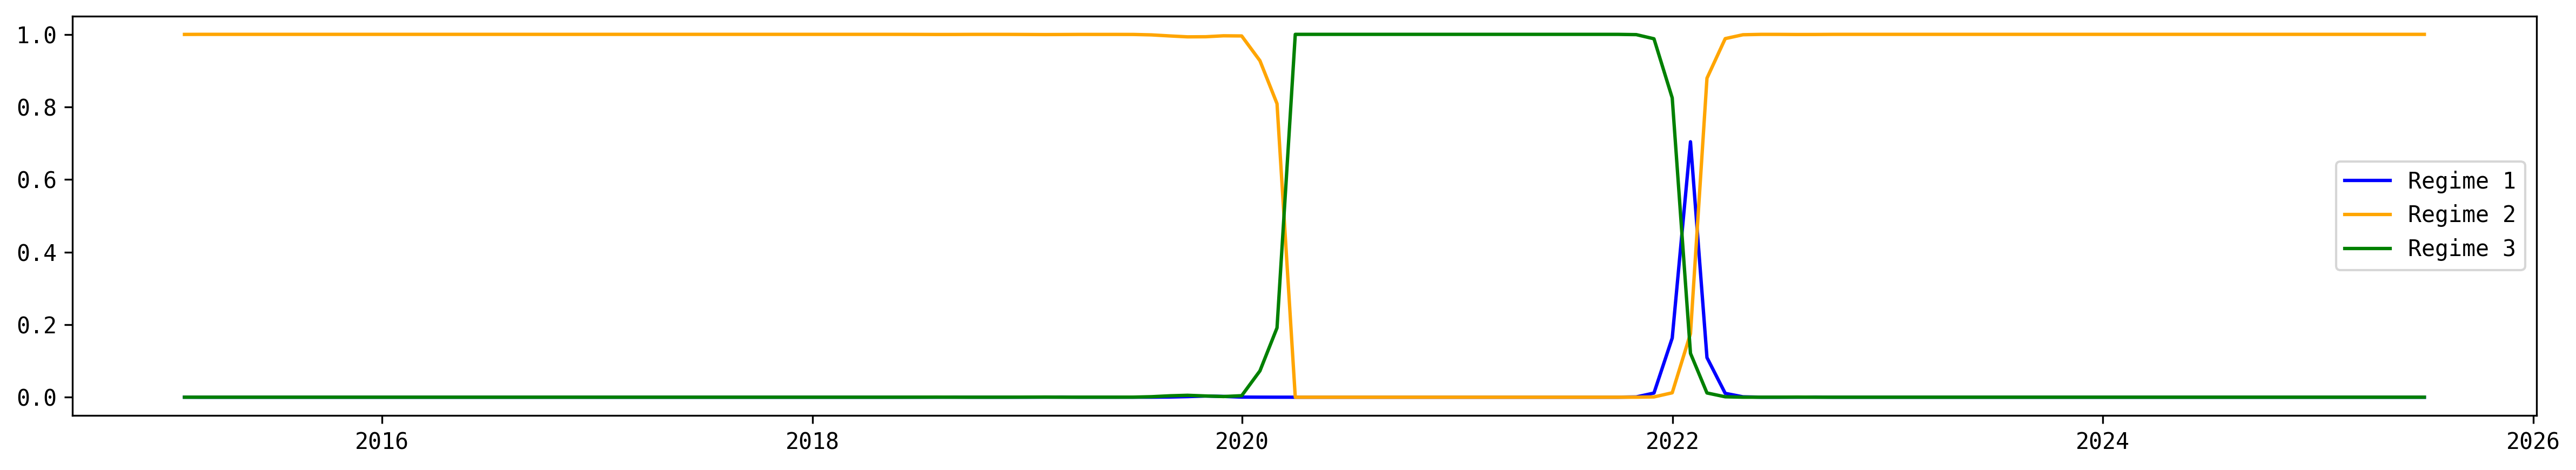

In [20]:
# Get regime probabilities
regime_probs = results_simple.smoothed_marginal_probabilities
regime_most_likely = np.argmax(regime_probs, axis=1)

plt.figure(figsize=(16, 3), dpi=300)

plt.plot(regime_probs.iloc[:, 0], label='Regime 1', color='blue')
plt.plot(regime_probs.iloc[:, 1], label='Regime 2', color='orange')
plt.plot(regime_probs.iloc[:, 2], label='Regime 3', color='green')
# plt.plot(regime_probs.iloc[:, 3], label='Regime 3', color='red')

plt.legend()
plt.tight_layout()
plt.show()

# 4. Lag structure - Seasonality Check

ACF & PACF on the stationary transform (from step 2) up to lag 24.  
• Flag if lag-12 spike exceeds lag-1 spike → strong annual seasonality.  
• Decide preliminary SARIMA orders:  
– p,P,q,Q ≤ 2 (small-sample rule of thumb).  
– d,D already chosen by ADF.  

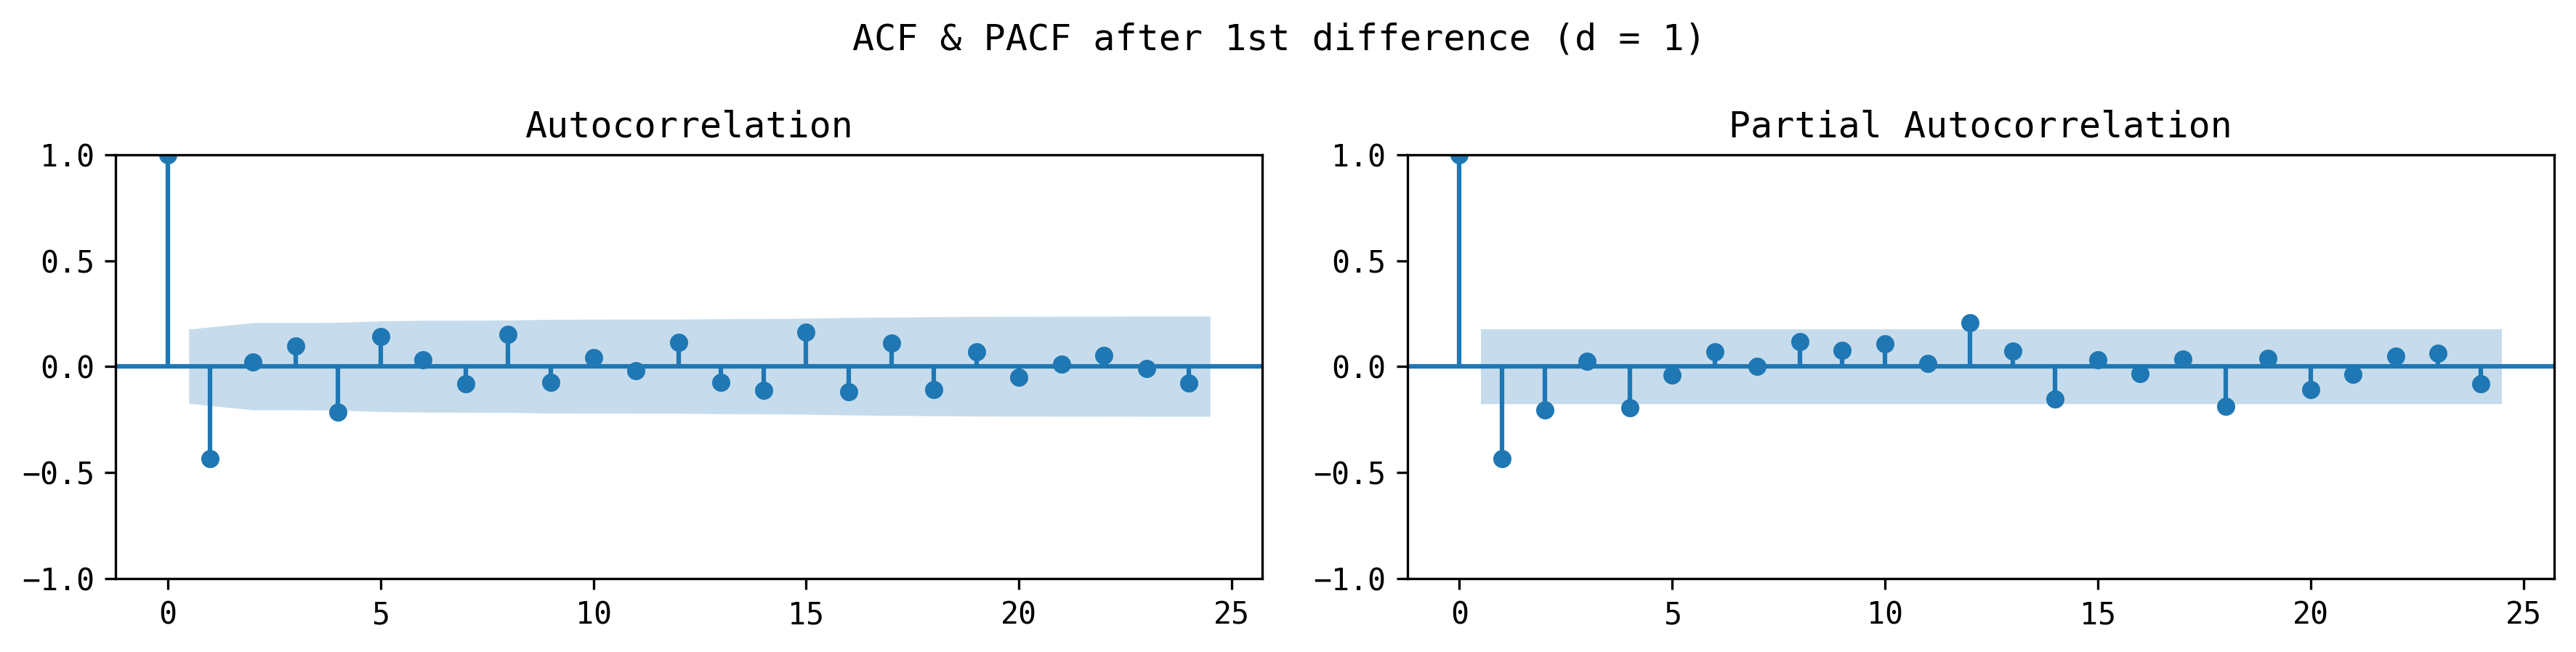

Lag-1 ACF  : -0.435
Lag-12 ACF :  0.115


In [21]:
y = merged['Retail_sales_index']
y_diff = y.diff().dropna()

# ACF & PACF up to lag 24
lags = 24
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=300)
sm.graphics.tsa.plot_acf(y_diff, lags=lags, ax=ax[0])
sm.graphics.tsa.plot_pacf(y_diff, lags=lags, ax=ax[1])
plt.suptitle('ACF & PACF after 1st difference (d = 1)')
plt.tight_layout()
plt.show()

# Pure-seasonality flag
acf_vals = sm.tsa.stattools.acf(y_diff, nlags=24, fft=False)
lag1_acf = acf_vals[1]
lag12_acf = acf_vals[12]

flag_seasonality = lag12_acf > lag1_acf
print(f'Lag-1 ACF  : {lag1_acf: .3f}')
print(f'Lag-12 ACF : {lag12_acf: .3f}')

In [22]:
# Candidate SARIMA orders (small-sample rule of thumb)
# d = 1 already fixed; D still needs to be chosen (often 0 or 1).
# p, P, q, Q capped at 2.

from itertools import product
p = q = P = Q = range(0, 3)  # 0, 1, 2
d = 1
D_candidates = [0, 1]  # choose the one that passes seasonal unit-root tests

orders = [(x[0], d, x[1], x[2], D, x[3])
          for D in D_candidates
          for x in product(p, q, P, Q)]

Recommended model: SARIMA(0,1,0)(0,1,0)[12]

# 5. Outliers in Remainder

• Compute STL remainder.  
• Robust Z-score (median ± 3·MAD).  
• Any point beyond ±3 tagged as additive outlier; keep list for later dummy.  

In [23]:
# Robust Z-score for resid obtained in STL decomposition
median_resid = np.median(resid)
mad_resid = np.median(np.abs(resid - median_resid))
robust_z_scores = (resid - median_resid) / (1.4826 * mad_resid)

# Additive outliers
outliers = np.where(np.abs(robust_z_scores) > 3)[0]
outlier_list = outliers.tolist()
print("Outliers indices:", outlier_list)

# Create dummy variables for outliers
n = len(res.observed)
dummy_variables = np.zeros(n)
for index in outlier_list:
    dummy_variables[index] = 1

print("Dummy Variables:", dummy_variables)

Outliers indices: [62, 64, 74, 83]
Dummy Variables: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


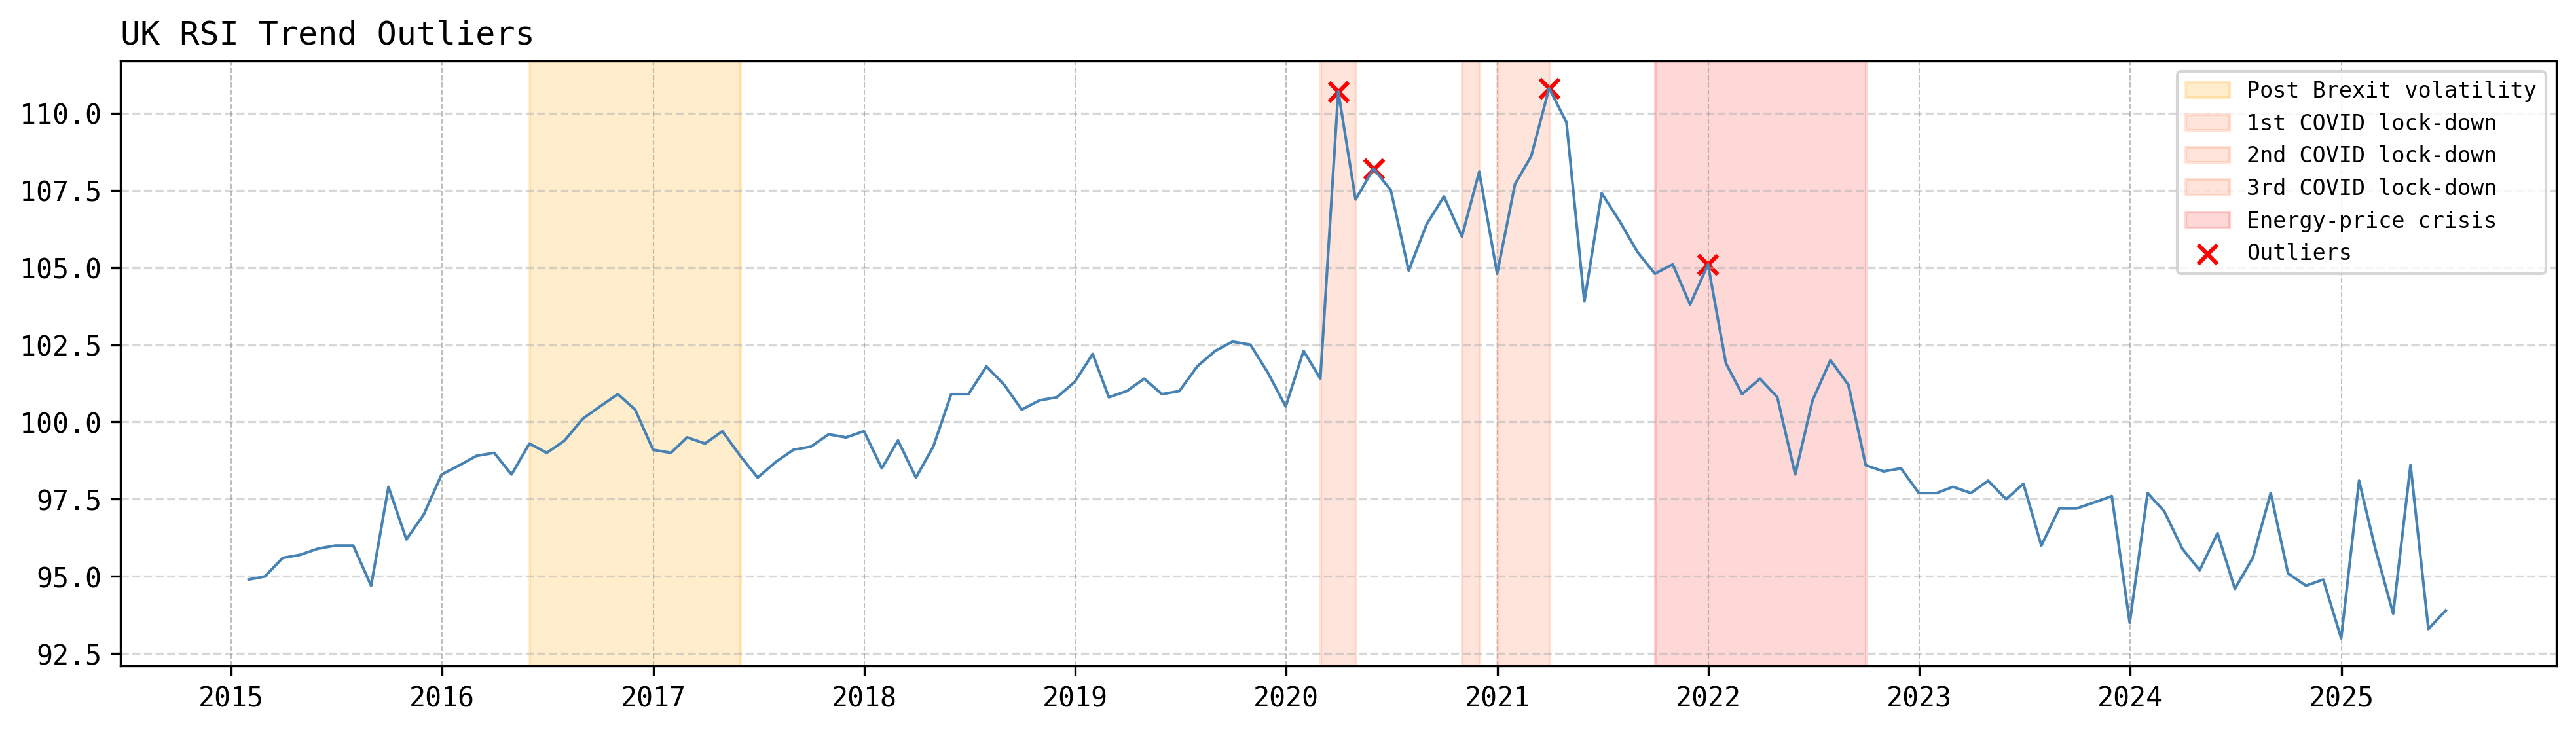

In [24]:
# Plot outliers on the chart
outlier_dates = merged.index[outlier_list]
outlier_values = merged.loc[outlier_dates, 'Retail_sales_index']

plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=merged, x='date', y='Retail_sales_index', linewidth=1, color='steelblue')

ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

event_spans = add_event_spans(ax)

# Add markers for outliers
ax.scatter(outlier_dates, outlier_values, color='red', marker='x', s=50, label='Outliers')

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('UK RSI Trend Outliers', loc='left')
plt.show()

In [25]:
# Append to the DataFrame
merged_with_features['is_outlier'] = False
merged_with_features.loc[outlier_dates, 'is_outlier'] = True
merged_with_features.head()

,Retail_sales_index,Consumer_confidence,CPI,cp_60,cp_85,is_outlier
date,,,,,,
2015-01-31,94.9,101.9632,101.3,0,0,False
2015-02-28,95.0,102.2298,101.1,0,0,False
2015-03-31,95.6,102.4168,100.9,0,0,False
2015-04-30,95.7,102.4100,100.5,0,0,False
2015-05-31,95.9,102.2814,100.4,0,0,False


# 6. Feature Relevance Preview (Correlation Sanity)

Spearman ρ matrix:  
sales_volume vs features.  
Look-ahead bias: exog variable must be shifted -1 lag.  
Drop any feature with |ρ| < 0.10 – saves noise for tree models.  

In [56]:
tmp_features = merged_with_features.copy()

In [57]:
orig_cols = tmp_features.columns.to_list()
orig_cols

['Retail_sales_index',
 'Consumer_confidence',
 'CPI',
 'cp_60',
 'cp_85',
 'is_outlier']

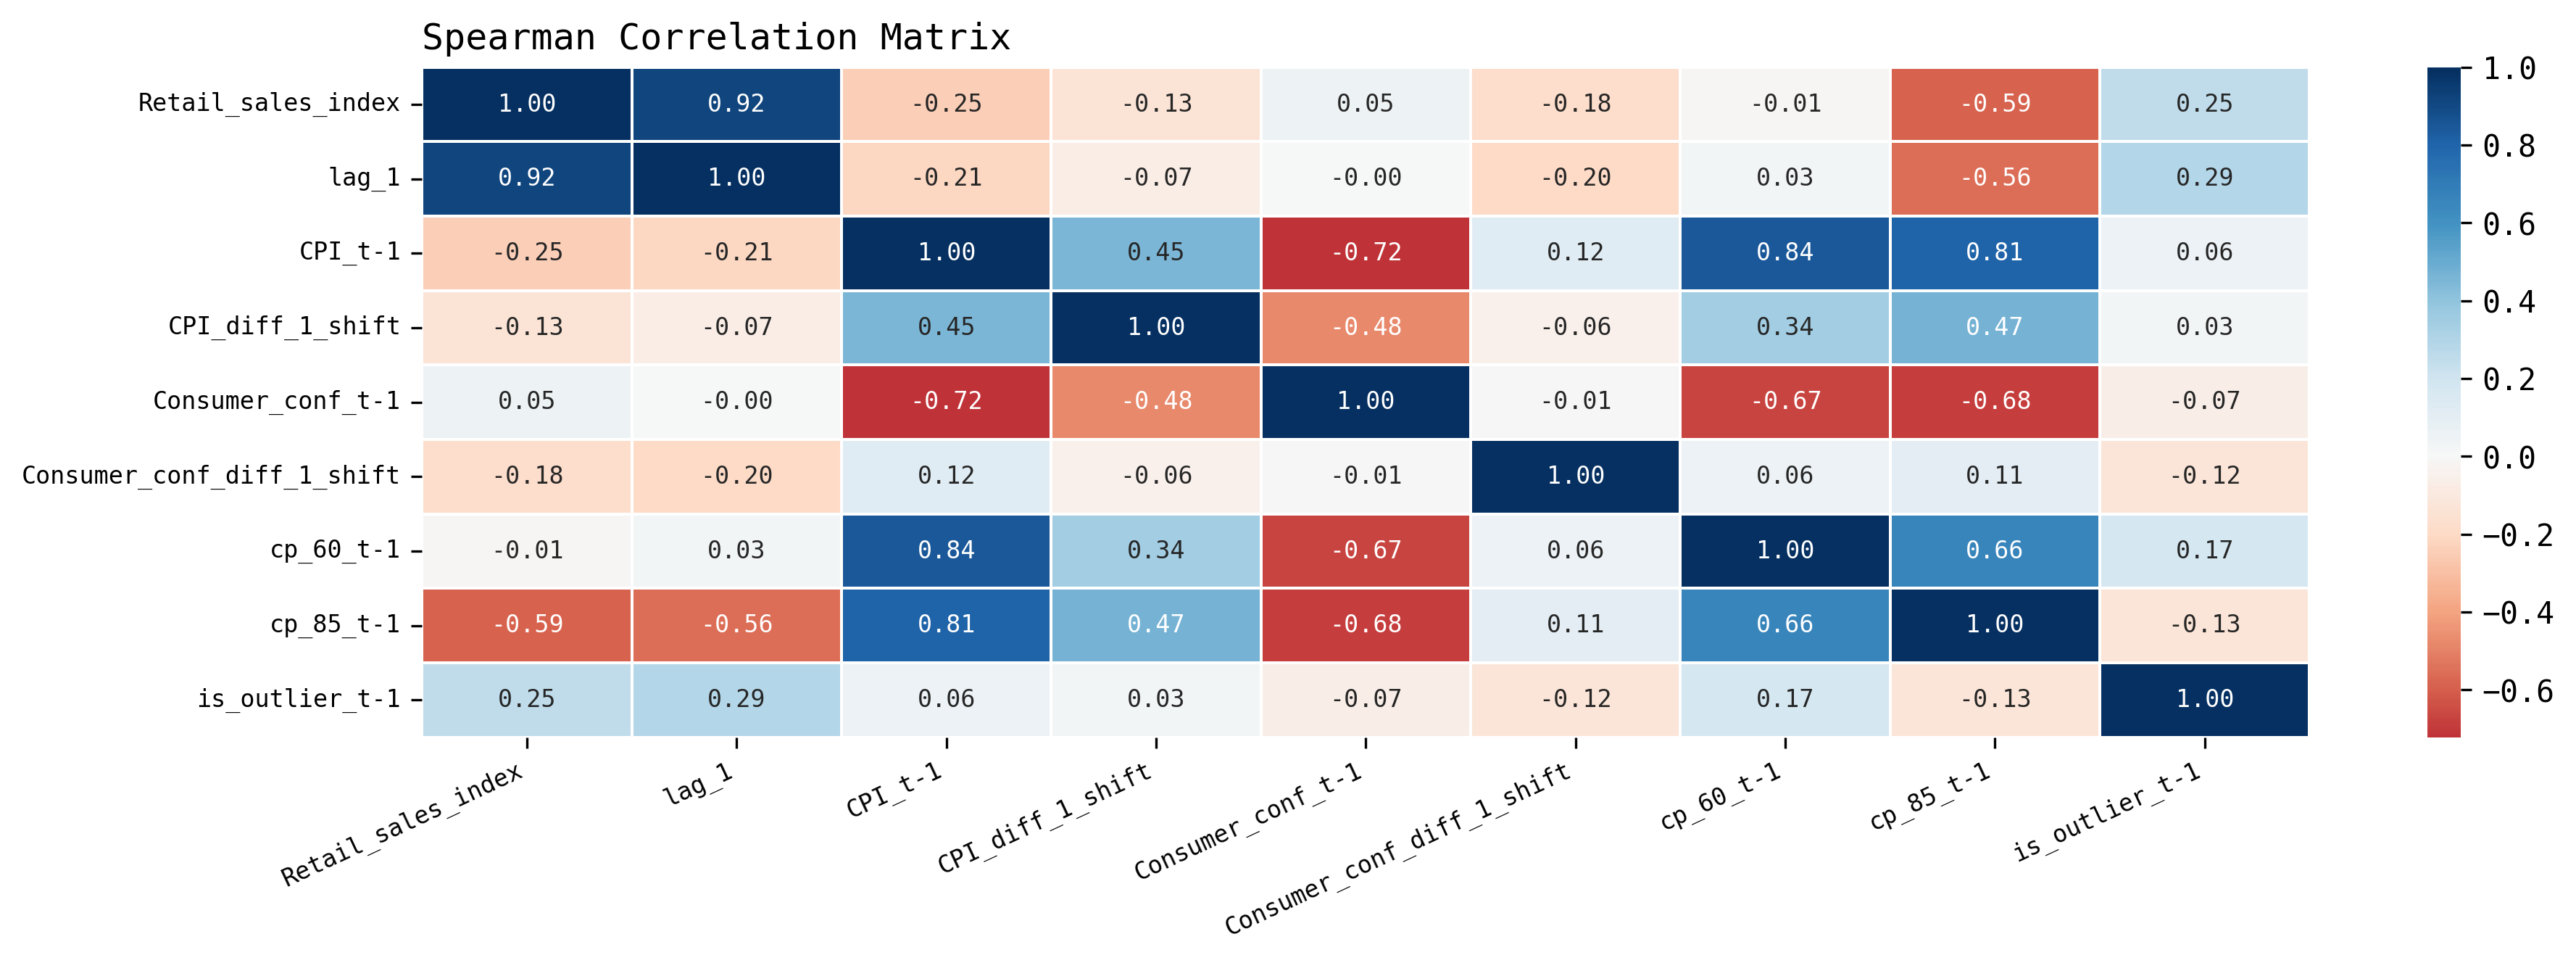

In [58]:
from scipy.stats import spearmanr

# uk_features['month'] = uk_features.index.month
tmp_features['lag_1'] = tmp_features['Retail_sales_index'].shift(1)
tmp_features['CPI_t-1'] = tmp_features['CPI'].shift(1)
tmp_features['CPI_diff_1_shift'] = tmp_features['CPI'].diff().shift(1)  # shifted difference to avoid leakage
tmp_features['Consumer_conf_t-1'] = tmp_features['Consumer_confidence'].shift(1)
tmp_features['Consumer_conf_diff_1_shift'] = tmp_features['Consumer_confidence'].diff().shift(1)
tmp_features['cp_60_t-1'] = tmp_features['cp_60'].shift(1)
tmp_features['cp_85_t-1'] = tmp_features['cp_85'].shift(1)
tmp_features['is_outlier_t-1'] = tmp_features['is_outlier'].shift(1)

tmp_features = tmp_features.dropna()
exclude_columns = orig_cols  # {'Retail_sales_index', 'CPI', 'Consumer_confidence'}
features_list = [col for col in tmp_features.columns if col not in exclude_columns]

# features = ['Consumer_conf_t-1', 'CPI_t-1', 'lag_1', 'cp_60', 'cp_85', 'is_outlier']
correlation_matrix = tmp_features[['Retail_sales_index'] + features_list].corr(method='spearman')

plt.figure(figsize=(14, 4), dpi=300)
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 8}, fmt='.2f', cmap='RdBu', center=0, linewidths=0.5, linecolor='white')
plt.title('Spearman Correlation Matrix', loc='left')
plt.xticks(fontsize=8, rotation=25, ha='right')
plt.yticks(fontsize=8)
plt.show()

In [59]:
# Identify features with |ρ| < 0.10
RSI_corr = correlation_matrix['Retail_sales_index'].abs()
features_to_drop = RSI_corr[RSI_corr < 0.10].index
features_to_keep = [col for col in features_list if col not in features_to_drop]
print("\nFeatures to drop: |ρ| < 0.10:")
print(features_to_drop.tolist())
print("\nFeatures to keep:")
print(features_to_keep)


Features to drop: |ρ| < 0.10:
['Consumer_conf_t-1', 'cp_60_t-1']

Features to keep:
['lag_1', 'CPI_t-1', 'CPI_diff_1_shift', 'Consumer_conf_diff_1_shift', 'cp_85_t-1', 'is_outlier_t-1']


In [61]:
# Create final DataFrame with selected features
df_features = tmp_features[features_to_keep + ['Retail_sales_index']].copy()

# Restore the index to the original dates
# df_features.index = merged.index[1:]
df_features.index = merged.index[1:1 + len(df_features)]
df_features.index.name = 'timestamp'  # Mandatory index name by TabPFN
df_features = df_features.asfreq('M')

# Prepare data in TabPFN friendly format
df_features = df_features.rename(columns={'Retail_sales_index': 'target'})
df_features = df_features[['target', 'cp_85_t-1', 'is_outlier_t-1', 'lag_1', 'CPI_t-1', 'CPI_diff_1_shift', 'Consumer_conf_diff_1_shift']]  # Mandatory target column order
# df_features['item_id'] = 0 # Mandatory column by TabPFN to be added in the modelling loop

# Save
df_features.to_pickle('../data/processed/dataset_with_features.pkl')

print("\nRemaining features after dropping low correlation features:")
print(df_features.info())
print("\nFinal DataFrame with selected features:")
df_features.head()


Remaining features after dropping low correlation features:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2015-02-28 to 2025-05-31
Freq: M
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   target                      124 non-null    float64
 1   cp_85_t-1                   124 non-null    float64
 2   is_outlier_t-1              124 non-null    object 
 3   lag_1                       124 non-null    float64
 4   CPI_t-1                     124 non-null    float64
 5   CPI_diff_1_shift            124 non-null    float64
 6   Consumer_conf_diff_1_shift  124 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.8+ KB
None

Final DataFrame with selected features:


,target,cp_85_t-1,is_outlier_t-1,lag_1,CPI_t-1,CPI_diff_1_shift,Consumer_conf_diff_1_shift
timestamp,,,,,,,
2015-02-28,95.6,0.0,False,95.0,101.1,-0.2,0.2666
2015-03-31,95.7,0.0,False,95.6,100.9,-0.2,0.1870
2015-04-30,95.9,0.0,False,95.7,100.5,-0.4,-0.0068
2015-05-31,96.0,0.0,False,95.9,100.4,-0.1,-0.1286
2015-06-30,96.0,0.0,False,96.0,100.2,-0.2,0.1399


In [62]:
# OPTIONAL: Save to a CSV file
df_features.to_csv(processed_data_dir / "uk_final_formatted.csv", index=True)

# 7. Calibration Stability Check for Training Data

Rolling 36-month mean & std of stationary series.  
30–36 observations is the smallest window in which the sample mean and standard deviation of a monthly series become reasonably precise.  
• If either drifts > 1 std, rolling-window conformal is mandatory instead of single-split.  
• Report break date when drift exceeds 2 σ.  

In [48]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2015-02-28 to 2025-06-30
Freq: M
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                125 non-null    float64
 1   cp_85                 125 non-null    int32  
 2   is_outlier            125 non-null    bool   
 3   lag_1                 125 non-null    float64
 4   CPI_t-1               125 non-null    float64
 5   Consumer_conf_diff_1  125 non-null    float64
dtypes: bool(1), float64(4), int32(1)
memory usage: 5.5 KB


In [49]:
# Focus on trainng set
tmp_monitoring = df_features.loc['2015-01':'2020-12'].copy()

# Keep floating-point series only
series_to_monitor = [
    col for col in tmp_monitoring.select_dtypes(include=['float64']).columns
    if col != 'target'
]

for col in series_to_monitor:
    p = adfuller(tmp_monitoring[col].dropna(), regression='c')[1]
    print(f'{col:<25} ADF p-value: {p:.3f}{"  <- non-stationary!" if p > 0.05 else ""}')

lag_1                     ADF p-value: 0.923  <- non-stationary!
CPI_t-1                   ADF p-value: 0.635  <- non-stationary!
Consumer_conf_diff_1      ADF p-value: 0.000


In [50]:
tmp_monitoring['lag_1_diff'] = tmp_monitoring['lag_1'].diff()
tmp_monitoring['CPI_t_1_diff'] = tmp_monitoring['CPI_t-1'].diff()
tmp_monitoring['Consumer_conf_diff_1'] = tmp_monitoring['Consumer_conf_diff_1'].diff()

tmp_monitoring = tmp_monitoring.dropna()

series_to_monitor = ['Consumer_conf_diff_1', 'lag_1_diff', 'CPI_t_1_diff']

for col in series_to_monitor:
    p = adfuller(tmp_monitoring[col].dropna(), regression='c')[1]
    print(f'{col:<25} ADF p-value: {p:.3f}{"  <- non-stationary!" if p > 0.05 else ""}')

Consumer_conf_diff_1      ADF p-value: 0.000
lag_1_diff                ADF p-value: 0.001
CPI_t_1_diff              ADF p-value: 0.064  <- non-stationary!


> CPI_t-1 fails stationarity after 1-5 period differencing.  
> CPI_t-1 to be treated as raw exogenous regressor and excluded from calibration, but kept for the analysis

In [ ]:
# Calibration stability check

series_to_monitor = ['Consumer_conf_diff_1', 'lag_1_diff']


def drift_stats(s, window=36):
    """
    Returns two Series:
      mean_drift: abs(rolling_mean - baseline_mean) / baseline_std
      std_drift : abs(rolling_std  - baseline_std)  / baseline_std
    baseline = first 'window' observations
    """
    baseline_mean = s.iloc[:window].mean()
    baseline_std = s.iloc[:window].std(ddof=1)

    rolling_mean = s.rolling(window).mean()
    rolling_std = s.rolling(window).std(ddof=1)

    mean_drift = (rolling_mean - baseline_mean).abs() / baseline_std
    std_drift = (rolling_std - baseline_std).abs() / baseline_std
    return mean_drift, std_drift


break_dates = {}
use_rolling_conformal = False

for col in series_to_monitor:
    mean_drift, std_drift = drift_stats(tmp_monitoring[col])

    # 1-sigma rule
    drifted = (mean_drift > 1.0) | (std_drift > 1.0)
    if drifted.any():
        use_rolling_conformal = True

    # 2-sigma rule → report first break date
    severe = (mean_drift > 2.0) | (std_drift > 2.0)
    if severe.any():
        break_dates[col] = severe.idxmax().strftime('%Y-%m-%d')
    else:
        break_dates[col] = None

# Print results
print('Calibration stability check (36-month rolling window)')
print('-' * 55)
print('Use rolling-window conformal instead of single-split? ',
      use_rolling_conformal)
print('\nFirst break date (> 2σ drift):')
for k, v in break_dates.items():
    print(f'   {k:<25} {v}')

Calibration stability check (36-month rolling window)
-------------------------------------------------------
Use rolling-window conformal instead of single-split?  True

First break date (> 2σ drift):
   Consumer_conf_diff_1      None
   lag_1_diff                None
